# Machine Translation
by Hanna Seyoum

## IV. Final Report

### 1. Problem Statement
I want to build a well performing neural machine translator, starting with english-french translations, to eventually translate less popular languages such as Amharic and Tigrinya.

### 2. Data Acquisition and Loading
I downloaded the data which is a zip file from manythings.org/anki. I used the module `zipfile` to find the .zip file and extract the .txt file that contained the data. I then opend the file and read it. Since each line contained a sentence pair of english and french text, and additional information, I split the data by linebreaks. And in each line, the english and french phrases were separated by a tab, so I separated them by tab and created a dataframe with two columns.

### 3. Methodology
**Data cleaning:** [Read Data](#Load-Data)  
The sentence pairs were tab-delimited, so I used pandas read_csv with `sep='\t'`.

**Data preprocessing:**  [Data Pre-processing](#Data-Pre-processing)  
I first defined a function, `unicode_to_ascii`, to normalize the unicode data. Then I defined a function, `preprocess_sentence`, that first applies the unicode_to_ascii function to each row and changes each letter to small cases and strips white spaces. The `preprocess_sentence` function then tokenizes each phrase by replacing all punctuation with spaces except for sentence ending punctuations. It also adds the `<start>` and `<end>` tokens at the begining and ending of each phrase. This is a crude tokenizer that reduces the number of tokens that the translation model must learn. Case folding can also be used to reduce the vocabulary size further.  

**Building Vocabulary Index:** [Building Vocabulary Index](#Building-Vocabulary-Index)  
I define a language index class that creates a word to index mapping (& vice versa) of the words in the sentence pairs. A separate index is created for each language.  

**Data Batching:** [Batching](#Load-data-into-DataLoader-for-Batching)  
I load the data into DataLoader for batching. This is just preparing the dataset so that it can be efficiently fed into the model through batches.

**Data Modeling:** [Data Modeling](#Data-Modeling)  
I use custom GRU encoder and decoder models, and define train and predict function that will first fit the encoder-decoder models, then predict the input sentences. Unlike SciKit-Learn, in PyTorch the `predict()` function is called `forward()`. And the `fit()` function is called `backward()` in PyTorch, because it is used by the optimizer for back-propagation to the weights. I have a wrapper function that chains the PyTorch encoder and decoder `forward()` and `backward()` functions together and optimizes the weights using the optimizer.

### 4. Initial Findings

Phrase Distribution:   
We see from the distribution and statistics that on average, french phrases tend to have more words per phrase than english phrases. 
    
Phrase Statistics:  
* 112079 English words in total
* 129852 French words in total
* Avg number of English words per phrase: 0.7 | standard deviation: 0.8
* Avg number of French words per phrase: 1.3 | standard deviation: 1.4
* Number of English words per phrase | minimum: 1, maximum: 7
* Number of French words per phrase | minimum: 1, maximum: 14

On average, French has more words per phrase than English.

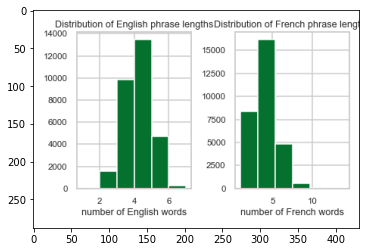

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

phrase_dist = mpimg.imread("phrase_dist.png")
phrase_dist_plot = plt.imshow(phrase_dist)
plt.show()

### 5. Statistical Analysis - Zipf's Law

Zipf's law is one of the most well-known laws in quantiative linguistics.
* It's a very simple power law. It relates the rank ($r$) of an ordered list item to the frequency of occurence ($p_{i}$) for this item:  
    $p_{i} = \frac{1}{i_{a}}$ => log$(p_{i})$ = $-a$log$(i)$, with $a \approx 1$
        
* It's validity has been observed in a wide range of phenomena, including natural languages, finance, ecological systems, and web statistics.

I calculated word frequencies of both english and french texts, calculated their ranks, and plotted their scatterplots with logarithmic scales. Both plots show that the ranks of frequency of words follow the Zipf's law. We have the ranks on the x-axis, and the word frequencies on the y-axis. The least frequent words have the highest ranks, while the most frequent words have the lowest ranks. If the plots were not on a logarithmic scale, we would notice the significant drop in word frequencies between the first few ranks, and the rank continues to reduce.

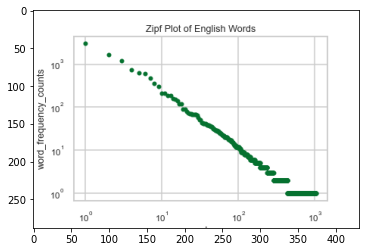

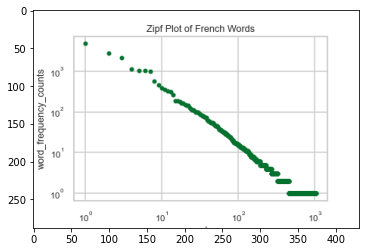

In [3]:
img_en = mpimg.imread("zipf_en.png")
img_fr = mpimg.imread("zipf_fr.png")
imgplot_en = plt.imshow(img_en)
plt.show()
imgplot_fr = plt.imshow(img_fr)
plt.show()

### 6. Data Modeling 

**A Brief History of machine translation**  
Initially machine translation (MT) problems were solved using statistics, mainly Bayes probabilities. As this approach was tedious and time consuming, researchers found a way to use neural networks for translation. This approach is called neural machine translation (NMT).

**My models:**   

**GRU**  
I have chosen to use GRU (Gated Recurrent Unit) models. GRU is a type of RNN that has better memory. During backpropagation, RNNs suffer from the vanishing gradient problem. The gradient is the value we use to update a neural network's weight. The vanishing gradient problem is when a gradient shrinks as it backpropagates through time. If a gradient value becomes too small, it doesn't contribute to much learning. So in RNNs, layers that get a small gradient update don't learn. Those are usually the earlier layers. So because these layers don't learn, RNNs can forget what is seen in longer sequences, thus having short term memory.  

GRU and Long Short-Term Memory (LSTM) were created as the solution to RNN's short term memory. They have internal mechanisms called gates that can regulate the flow of information. These gates can learn which data in a sequence is important to keep or throw away. By doing that it learns to use relevant information to make predictions.

GRU and LSTM have some differences. GRU has 2 gates while LSTM has 4 gates, leading to a faster performance of GRU. Therefore I have built the models based on GRU for this project.

**seq2seq -- Encoder & Decoder**  
The NMT processes an input sequence to produce an output sequence, and this is called a sequence-to-sequence (seq2seq) problem. With a seq2seq problem, we build an encoder and a decoder. The encoder receives sequences from the source language as inputs and produces a condensed representation of that sequence, containing a summary of all the input's information. In other words, the encoder outputs several hidden layers, which are vectors, that we do not see, and it returns 1 vector that was chosen to be the best representative of the input information. That returned vector that is reduced to a smaller dimension is the embedding dimension. The embedded vector becomes an input to the decoder. At each time step, the decoder generates an element of its output sequence based on the input received and its current state, as well as updating its own state for the next time step. See summary below for step by step explanation.  

**Summary of steps taken to train the GRU model:**  
- Passed the input through the encoder which return encoder output and the encoder hidden state.
- The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
- The decoder returns the predictions and the decoder hidden state.
- The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
- Use teacher forcing to decide the next input to the decoder.
- Teacher forcing is the technique where the target word is passed as the next input to the decoder.
- The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


### 7. Results

Some observations:  

I noticed that higher `embedding_dim` resulted in lower total loss. This is because the higher the embedding dimension the more information was contained on the input sequence.


**Hyperparameter Tuning Table**

In [4]:
import pandas as pd
hyperparam_table = pd.read_csv("hyperparam_table.csv")
hyperparam_table = hyperparam_table.sort_values(by="total_loss")
hyperparam_table.head()

,encoder,decoder,batch_loss,num_epochs,num_batches,total_loss,layer_enc_units,dec_units,embedding_dim,batch_size,lr
20,"GRUEncoder(\n (embedding): Embedding(763, 32)\n)","Decoder(\n (embedding): Embedding(428, 32)\n ...","tensor(0.0232, grad_fn=<DivBackward0>)",50,25,"tensor(0.0283, grad_fn=<DivBackward0>)",[32],32,32.0,32,0.03
18,"GRUEncoder(\n (embedding): Embedding(763, 32)\n)","Decoder(\n (embedding): Embedding(428, 32)\n ...","tensor(0.0470, grad_fn=<DivBackward0>)",50,12,"tensor(0.0438, grad_fn=<DivBackward0>)",[32],32,32.0,64,0.03
13,"GRUEncoder(\n (embedding): Embedding(763, 16)\n)","Decoder(\n (embedding): Embedding(428, 16)\n ...","tensor(0.0766, grad_fn=<DivBackward0>)",20,25,"tensor(0.0559, grad_fn=<DivBackward0>)",[1024],1024,16.0,32,0.03
11,"GRUEncoder(\n (embedding): Embedding(763, 32)\n)","Decoder(\n (embedding): Embedding(428, 32)\n ...","tensor(0.0567, grad_fn=<DivBackward0>)",20,25,"tensor(0.0665, grad_fn=<DivBackward0>)",[256],256,32.0,32,0.03
7,"GRUEncoder(\n (embedding): Embedding(763, 16)\n)","Decoder(\n (embedding): Embedding(428, 16)\n ...","tensor(0.1088, grad_fn=<DivBackward0>)",20,25,"tensor(0.0787, grad_fn=<DivBackward0>)",[64],64,16.0,32,0.03


**Actual - Predicted Sentences**  
Below is a table showing the results that were generated by using the hyperparameters that had the least loss. It contains the input sentence in French, the predicted (translated) sentence in English, and the true English translation.  

The hyperparameters are:  

num_epochs = 50  
lr = 0.03  
batch_size = 32  
embedding_dim = 32.0  
layer_enc_units = 32  
dec_units = 32  

In [36]:
best_translations = pd.read_csv("best_translation_800.csv")
best_translations

,french,predicted_english,truth_english
0,Je suis en avance .,I m early .,I m early .
1,Je suis fou .,I m crazy .,I m crazy .
2,Aidez moi .,Help me .,Help me .
3,Embrassez moi .,Kiss me .,Kiss me .
4,Garde c a .,Keep this .,Keep that .
...,...,...,...
795,Je vous en prie !,Oh please !,Oh please !
796,Tenez ceci !,Hold this .,Hold this .
797,Prends le !,Take it .,Take it .
798,Formidable !,Terrific !,Terrific !


### 8. Conclusion
The model has performed well with only 2% loss. However this is expected as it is the training loss. In the future I will evaluate the test set.

### 9. Next Steps
* Train on entire dataset instead of a small sample
* Build LSTM model
* Calculate loss on test set

### 10. Code

#### Import Libraries

In [6]:
import torch
import torch.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import unicodedata
import re
import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import operator

from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=0.7)
sns.set_palette("Greens_r")

'''
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(f'torch.__version__: {torch.__version__}')
print(f'torch device: {device}')
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import FloatTensor, IntTensor, LongTensor  # noqa
if str(device) == 'gpu':
    from torch.cuda import FloatTensor, IntTensor, LongTensor  # noqa

print(f'torch.__version__: {torch.__version__}')
print(f'torch device: {device}')
print(f'IntTensor: {IntTensor}')
print(f'LongTensor: {LongTensor}')

torch.__version__: 1.7.1
torch device: cpu
IntTensor: <class 'torch.IntTensor'>
LongTensor: <class 'torch.LongTensor'>


#### Defining Variables

In [7]:
source_lang_name = "french"
target_lang_name = "english"
SOS_TOKEN = '<start>'
EOS_TOKEN = '<end>'
PAD_TOKEN = '<pad>'
OOV_TOKEN = '<oov>'
DUMMY_TOKENS = [SOS_TOKEN, EOS_TOKEN, PAD_TOKEN, OOV_TOKEN]

# Toy Problem
NUM_EXAMPLES = 1000
NUM_EPOCHS = 50
LEARNING_RATE = 0.03
BATCH_SIZE = 32
EMBEDDING_DIM = 32
LAYER_NUM_UNITS = [32] # neurons

#### Dataset:  Bilingual Sentence pairs
Download [manythings.org/anki/fra-eng.zip](http://www.manythings.org/anki/fra-eng.zip)

#### Load Data

In [8]:
from zipfile import ZipFile
with ZipFile('../Capstone-Project-2/data/fra-eng.zip', 'r') as zipobj:
   # Get a list of all archived file names from the zip
   # filenames = zipobj.namelist()
   zipobj.extract('fra.txt')

In [9]:
df = pd.read_csv('fra.txt', sep='\t', nrows=NUM_EXAMPLES, header=None, usecols=range(2))
#df = pd.read_csv('fra.txt', sep='\t', header=None, usecols=range(2))
df.columns = [target_lang_name, source_lang_name]
df.head(5)

,english,french
0,Go.,Va !
1,Hi.,Salut !
2,Hi.,Salut.
3,Run!,Cours !
4,Run!,Courez !


#### Data Pre-processing

In [10]:
def preprocess_sentence(w):
    r""" tokenize a phrase by replacing all punctuations with spaces except for sentence ending punctuations.
    also adds the <start> and <end> token
    """
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    
    w = SOS_TOKEN + ' ' + w + ' ' + EOS_TOKEN
    return w

In [11]:
# apply the preprocessing using pandas and lambdas
for col in df.columns:
    df[col] = df[col].apply(lambda w: unicodedata.normalize('NFD', w))
    df[col] = df[col].apply(lambda w: preprocess_sentence(w))

df.sample(10)

,english,french
994,<start> Tom s sad . <end>,<start> Tom est triste . <end>
860,<start> Let s eat . <end>,<start> Mangeons . <end>
982,<start> Tom fired . <end>,<start> Tom a tire . <end>
344,<start> I ll try . <end>,<start> J essaierai . <end>
577,<start> Go get it . <end>,<start> Va le chercher ! <end>
958,<start> Thank you . <end>,<start> Je vous remercie . <end>
687,<start> I tripped . <end>,<start> J ai tre buche . <end>
511,<start> Bless you . <end>,<start> A tes souhaits ! <end>
81,<start> Be calm . <end>,<start> Soyez calmes ! <end>
527,<start> Come over ! <end>,<start> Venez ! <end>


#### Building Vocabulary Index

In [12]:
class LanguageIndex():
    r""" Create a word to index mapping (& vice versa)
    ex. "hello" -> 47 and 47 -> "hello"    
    """
    
    def __init__(self, phrases, name=None):
        """ `phrases` is a list of phrases in one language """
        self.name = name  # 'english', 'spanish', etc
        self.word2idx = {}
        self.vocab = []
        self.size = 0
        self.idx2word = self.vocab  # this can just be a list
        self.max_phrase_length = 0
        self.create_index(phrases)

    def create_index(self, phrases):
        self.vocab = set(DUMMY_TOKENS)
        for phrase in phrases:
            tokens = phrase.split()
            self.max_phrase_length = max(self.max_phrase_length, len(tokens))
            self.vocab.update(set(tokens))
        self.vocab = sorted(self.vocab)

        self.idx2word = self.vocab
        self.size = len(self.idx2word)
        self.word2idx = dict(zip(self.vocab, range(len(self.vocab))))

    def get(self, tok, default=None):
        if isinstance(tok, int):
            if (0 <= tok < self.size):
                return self.idx2word[tok]
            return None
        return self.word2idx.get(tok, default)

    def __getitem__(self, tok):
        if isinstance(tok, int):
            return self.idx2word[tok]
        return self.word2idx[tok]


In [13]:
# index language using the class above
input_word_index = LanguageIndex(df[source_lang_name].values.tolist())
target_word_index = LanguageIndex(df[target_lang_name].values.tolist())
#input_word_index = LanguageIndex(phrases=df[source_lang_name].values, name=source_lang_name)
#target_word_index = LanguageIndex(phrases=df[target_lang_name].values, name=target_lang_name)

# Vectorize the input and target languages
input_tensors = [[input_word_index.word2idx[w] for w in phrase.split(' ')]  for phrase in df[source_lang_name].values.tolist()]
target_tensors = [[target_word_index.word2idx[w] for w in phrase.split(' ')]  for phrase in df[target_lang_name].values.tolist()]
input_tensors[:10]

[[6, 225, 0, 3],
 [6, 188, 0, 3],
 [6, 188, 2, 3],
 [6, 58, 0, 3],
 [6, 57, 0, 3],
 [6, 169, 7, 3],
 [6, 44, 236, 256, 0, 3],
 [6, 32, 409, 0, 3],
 [6, 8, 463, 247, 0, 3],
 [6, 191, 2, 3]]

In [14]:
target_tensors[:10]

[[6, 48, 2, 3],
 [6, 61, 2, 3],
 [6, 61, 2, 3],
 [6, 94, 0, 3],
 [6, 94, 0, 3],
 [6, 137, 7, 3],
 [6, 138, 0, 3],
 [6, 43, 0, 3],
 [6, 59, 0, 3],
 [6, 71, 2, 3]]

In [15]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
# calculate the max_length of input and output tensor
max_length_inp, max_length_tar = max_length(input_tensors), max_length(target_tensors)

In [17]:
def pad_token_id_list(s, max_len, pad_tok_idx):
    """ Add the padding token id to the end of the list of integers to ensure uniform length

    TODO: make this a method within the LanguageIndex so the pad_tok_idx is known within self

    Input:
      max_len (int): maximum number of tokens in a sentence
      pad_tok_idx (int): the id of the token '<pad>' for the sentence (language) being padded
    Output:
      sequence of ints with the integer pad token appended to the end
    """
    padded = pad_tok_idx * np.ones(max_len, dtype=np.int64)  # FIXME: int16 should be plenty
    s_len = min(max_len, len(s))
    padded[:s_len] = s[:s_len]
    return padded


In [18]:
# inplace padding
input_tensors = [pad_token_id_list(x, max_length_inp, input_word_index.word2idx[PAD_TOKEN]) for x in input_tensors]
target_tensors = [pad_token_id_list(x, max_length_tar, target_word_index.word2idx[PAD_TOKEN]) for x in target_tensors]
#input_tensors = [pad_token_id_list(x, max_length_inp, input_word_index[PAD_TOKEN]) for x in input_tensors]
#target_tensors = [pad_token_id_list(x, max_length_tar, target_word_index[PAD_TOKEN]) for x in target_tensors]

len(target_tensors)

1000

In [19]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensors, target_tensors, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(800, 800, 200, 200)

#### Load data into DataLoader for Batching
This is just preparing the dataset so that it can be efficiently fed into the model through batches.

In [20]:
from torch.utils.data import Dataset, DataLoader

In [21]:
class TranslationDataset(Dataset):
    r""" convert the data to tensors and pass to the Dataloader to create a batch iterator
    """
    def __init__(self, X, y):
        self.data = X
        self.target = y
        # TODO: vectorize with torch.tensor
        self.length = [ np.sum(1 - np.equal(x, 0)) for x in X]
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x_len = self.length[index]
        return x, y, x_len
    
    def __len__(self):
        return len(self.data)

### Data Modeling

#### Parameters
Let's define the hyperparameters and other things we need for training our NMT model.

In [22]:
BUFFER_SIZE = len(input_tensor_train)
N_BATCH = BUFFER_SIZE // BATCH_SIZE
vocab_inp_size = len(input_word_index.word2idx) # or input_word_index.size
vocab_tar_size = len(target_word_index.word2idx) # or target_word_index.size

train_dataset = TranslationDataset(input_tensor_train, target_tensor_train)
val_dataset = TranslationDataset(input_tensor_val, target_tensor_val)

dataset = DataLoader(train_dataset, batch_size = BATCH_SIZE, 
                     drop_last=True,
                     shuffle=True)

#### Building GRU Encoder

In [23]:
# GRU
class GRUEncoder(nn.Module):
    def __init__(self, 
                 vocab_size=vocab_inp_size, 
                 embedding_dim=EMBEDDING_DIM, 
                 layer_enc_units=LAYER_NUM_UNITS, 
                 batch_size=BATCH_SIZE,
                device=device):
        super().__init__()
        self.batch_size = batch_size
        self.layer_enc_units = layer_enc_units # used to determine how big the GRU layer is
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.device = device
        
        # creating layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        # an embedding: it's a vector that represents a (single) word
        # an embedding layer: creates embedding vectors from the input words
        self.gru_layers = []
        for enc_units in self.layer_enc_units:
            self.gru_layers.append(nn.GRU(self.embedding_dim, enc_units))

        # nn: module, 
        # GRU is a class definition of a neural network layer (nn.Module)
        # what happens when we call the class definition GRU? nn.GRU()
        # we create (instantiate) an object by calling the __init__ function of that class definition
        # with the arguments specifying what we want
        # In other words: we instantiate an instance of the class GRU and assign it to the variable self.gru1
        
    def forward(self, X, lengths=None, device=device):
        lengths = LongTensor([len(s) for s in X]) if lengths is None else lengths
        # x.shape: (batch_size, max_length)
        
        # an embedding: it's a vector that represents a (single) word
        # an embedding layer: creates embedding vectors from the input words
        X = self.embedding(X) 
        # x.shape: (batch_size, max_length, embedding_dim)
                
        # x transformed = max_len X batch_size X embedding_dim
        # x = x.permute(1, 0, 2)
        self.output = pack_padded_sequence(X, lengths) # unpad
        
        self.hidden = self.initialize_hidden_state()
        
        # output: max_length, batch_size, enc_units
        # self.hidden: 1, batch_size, enc_units
        # gru returns hidden state of all timesteps as well as hidden state at last timestep
        for gru in self.gru_layers:
            self.output, self.hidden = gru(self.output, self.hidden)
            
        # pad the sequence to the max length in the batch
        self.output, _ = pad_packed_sequence(self.output)
        
        return self.output, self.hidden

    def initialize_hidden_state(self):
        torch.zeros((1, self.batch_size, self.layer_enc_units[-1])).to(self.device)

In [24]:
def sort_batch(X, y, lengths):
    r""" sort batch function to be able to use with pad_packed_sequence """
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

#### Building GRU Decoder

In [25]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 embedding_dim=EMBEDDING_DIM,
                 layer_enc_units=LAYER_NUM_UNITS,
                 dec_units=LAYER_NUM_UNITS[-1],
                 batch_size=BATCH_SIZE):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.enc_units = layer_enc_units[-1]
        self.dec_units = dec_units
        self.batch_size = batch_size

        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim + self.enc_units,
                          self.dec_units,
                          batch_first=True)
        self.fc = nn.Linear(self.enc_units, self.vocab_size)

        # used for attention
        self.W1 = nn.Linear(self.enc_units, self.dec_units)
        self.W2 = nn.Linear(self.enc_units, self.dec_units)
        self.V = nn.Linear(self.enc_units, 1)

    def forward(self, X, hidden, enc_output):
        # enc_output original: (max_length, batch_size, enc_units)
        # enc_output converted == (batch_size, max_length, hidden_size)
        enc_output = enc_output.permute(1, 0, 2)
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score

        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        hidden_with_time_axis = hidden.permute(1, 0, 2)

        # score: (batch_size, max_length, hidden_size) # Bahdanaus's
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        # It doesn't matter which FC we pick for each of the inputs
        score = torch.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis))

        # score = torch.tanh(self.W2(hidden_with_time_axis) + self.W1(enc_output))

        # attention_weights shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        attention_weights = torch.softmax(self.V(score), dim=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = torch.sum(context_vector, dim=1)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        # takes case of the right portion of the model above (illustrated in red)
        X = self.embedding(X)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        # x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # ? Looks like attention vector in diagram of source
        X = torch.cat((context_vector.unsqueeze(1), X), -1)

        # passing the concatenated vector to the GRU
        # output: (batch_size, 1, hidden_size)
        output, state = self.gru(X)

        # output shape == (batch_size * 1, hidden_size)
        output = output.view(-1, output.size(2))

        # output shape == (batch_size * 1, vocab)
        X = self.fc(output)

        return X, state, attention_weights
    
    def initialize_hidden_state(self):
        return torch.zeros((1, self.batch_sz, self.dec_units))

In [26]:
criterion = nn.CrossEntropyLoss()

def loss_function(real, pred):
    """ Only consider non-zero inputs in the loss; mask needed """
    #mask = 1 - np.equal(real, 0) # assign 0 to all above 0 and 1 to all 0s
    #print(mask)
    mask = real.ge(1).type(torch.FloatTensor)
    
    loss_ = criterion(pred, real) * mask 
    return torch.mean(loss_)

In [27]:
gruencoder = GRUEncoder(vocab_size=vocab_inp_size, embedding_dim=EMBEDDING_DIM, layer_enc_units=LAYER_NUM_UNITS, batch_size=BATCH_SIZE)
grudecoder = Decoder(vocab_size=vocab_tar_size, embedding_dim=EMBEDDING_DIM, dec_units=LAYER_NUM_UNITS[-1], layer_enc_units=LAYER_NUM_UNITS, batch_size=BATCH_SIZE)

gruencoder.to(device)
grudecoder.to(device)

OPTIMIZER = optim.Adam(list(gruencoder.parameters()) + list(grudecoder.parameters()), 
                       lr=LEARNING_RATE)


#### Training

In [28]:
print(' '.join([target_word_index.idx2word[i] for i in target_tensors[100]]))
print(' '.join([input_word_index.idx2word[i] for i in input_tensors[100]]))

<start> Call us . <end> <pad> <pad>
<start> Appelez nous ! <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [29]:
def train(encoder=gruencoder, decoder=grudecoder, optimizer=OPTIMIZER, num_epochs=NUM_EPOCHS):
    for epoch in tqdm(range(num_epochs)):
        start = time.time()

        encoder.train()
        decoder.train()

        total_loss = 0
        num_batches = 0

        for (batch, (inp, targ, inp_len)) in enumerate(dataset):
            loss = 0

            num_batches += 1
            xs, ys, lengths = sort_batch(X=inp, y=targ, lengths=inp_len)
            enc_output, enc_hidden = encoder(xs.to(device), lengths, device=device)
            dec_hidden = enc_hidden

            # use teacher forcing - feeding the target as the next input (via dec_input)
            dec_input = torch.tensor([[target_word_index.word2idx[SOS_TOKEN]]] * BATCH_SIZE)

            # run code below for every timestep in the ys batch
            for t in range(1, ys.size(1)):
                predictions, dec_hidden, _ = decoder(dec_input.to(device),
                                                     dec_hidden.to(device),
                                                     enc_output.to(device))
                loss += loss_function(ys[:, t].to(device), predictions.to(device))
                # loss += loss_
                dec_input = ys[:, t].unsqueeze(1)

            batch_loss = (loss / int(ys.size(1)))
            total_loss += batch_loss

            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

        # print('Epoch {} Loss {:.4f}'.format(batch, batch_loss.detach().item()))

        # TODO: Save checkpoint for model
        #print(f"Epoch {(epoch+1):03d} Loss {total_loss / N_BATCH:.2f}  Time:{(time.time()-start):03.3f} s")
        
        #mean_loss = total_loss/num_batches
        total_loss = total_loss/num_batches
        
        
    return dict(
        encoder=encoder,
        decoder=decoder,
        batch_loss=batch_loss,
        total_loss=total_loss,
        num_epochs=num_epochs,
        num_batches=num_batches,
        #mean_loss=mean_loss,
        #input_sentences=input_sentences,
        #target_sentences=target_sentences,
        #predicted_sentences=translated_sentences
    )

In [30]:
train_results = train(encoder=gruencoder, decoder=grudecoder, optimizer=OPTIMIZER, num_epochs=NUM_EPOCHS)

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


In [31]:
def convert_to_sentence(int_seq, vocab=target_word_index):
    token_seq = [vocab[int(tok.item())] for tok in int_seq]
    token_seq = [tok for tok in token_seq if tok not in DUMMY_TOKENS]
    return ' '.join(token_seq)


def convert_to_sentences(batch, vocab=target_word_index):
    sentences = []
    for int_seq in batch:
        sentences.append(convert_to_sentence(int_seq, vocab=vocab))
    return sentences

In [32]:
def predict(dataset=dataset, num_batches=10, encoder=gruencoder, decoder=grudecoder):
    """ Calculates total (average) loss and returns translated sentences, correct translations (truth) etc """
    target_sentences = []
    translated_sentences = []
    input_sentences = []
    total_loss = 0
    for (batch_num, (inp, targ, inp_len)) in enumerate(dataset):
        if num_batches is not None and batch_num >= num_batches:
            break
        loss = 0

        # FIXME: don't sort
        Xs, ys, lengths = sort_batch(X=inp, y=targ, lengths=inp_len)
        enc_output, enc_hidden = encoder(Xs.to(device), lengths, device=device)
        dec_hidden = enc_hidden

        final_sentences = Variable(torch.zeros(ys.size()))

        # winnie:   ( use teacher forcing - feeding the target as the next input (via dec_input))
        # dec_input = torch.tensor([target_word_index.word2idx[SOS_TOKEN]] * BATCH_SIZE)

        # original: ( use teacher forcing - feeding the target as the next input (via dec_input))
        dec_input = torch.tensor([[target_word_index.word2idx[SOS_TOKEN]]] * BATCH_SIZE)
        final_sentences[:, 0] = LongTensor([target_word_index.word2idx[SOS_TOKEN]] * BATCH_SIZE)

        # run code below for every timestep in the ys for this batch
        for t in range(1, ys.size(1)):
            predictions, dec_hidden, _ = decoder(dec_input.to(device),
                                                 dec_hidden.to(device),
                                                 enc_output.to(device))
            loss += loss_function(ys[:, t].to(device), predictions.to(device))
            predictions = predictions.squeeze(0)
            final_sentences[:, t] = predictions.argmax(axis=1)

            dec_input = ys[:, t].unsqueeze(1)

        target_sentences.extend(convert_to_sentences(ys, vocab=target_word_index))
        translated_sentences.extend(convert_to_sentences(final_sentences, vocab=target_word_index))
        input_sentences.extend(convert_to_sentences(Xs.numpy().T, vocab=input_word_index))

        batch_loss = (loss / int(ys.size(1)))
        total_loss += batch_loss

    total_loss = total_loss / batch_num
    return dict(
        batch_loss=batch_loss,
        total_loss=total_loss,
        input_sentences=input_sentences,
        target_sentences=target_sentences,
        predicted_sentences=translated_sentences)


In [33]:
def print_results(num_batches=10, results=None):
    print()
    if results is None:
        results = predict(num_batches=num_batches)
    
    triplets = list(zip(results['input_sentences'], results['predicted_sentences'], results['target_sentences']))
    
    print('-' * 60)
    print(f'------------- total_loss: {results["total_loss"]} -------------')
    print('-' * 60)
    
    print()
    return pd.DataFrame(triplets, columns=[
        f'{source_lang_name}',
        f'predicted_{target_lang_name}',
        f'truth_{target_lang_name}'])


In [34]:
results = predict(num_batches=None)
triplets = print_results(results=results)
triplets


------------------------------------------------------------
------------- total_loss: 0.01978055015206337 -------------
------------------------------------------------------------



,french,predicted_english,truth_english
0,Je suis en avance .,I m early .,I m early .
1,Je suis fou .,I m crazy .,I m crazy .
2,Aidez moi .,Help me .,Help me .
3,Embrassez moi .,Kiss me .,Kiss me .
4,Garde c a .,Keep this .,Keep that .
...,...,...,...
795,Je vous en prie !,Oh please !,Oh please !
796,Tenez ceci !,Hold this .,Hold this .
797,Prends le !,Take it .,Take it .
798,Formidable !,Terrific !,Terrific !


In [35]:
triplets.to_csv("best_translation_800.csv", index=False)